## **Goal: Use our actual churn model + bandit agent to decide promotions**

---

### **What we'll integrate explicitly:**

| Component                    | Source                                  |
|-----------------------------|-----------------------------------------|
| `Churn_Prob`                | From your trained model (e.g., Random Forest)  
| `CLV`, `Engagement_Score`, etc. | Already in `processed_customer_churn_data.csv`  
| `Action` (promotion or not) | Bandit agent (Thompson Sampling)  
| `Reward`                    | Based on real action & churn probability

---

## **Step-by-step integration logic:**

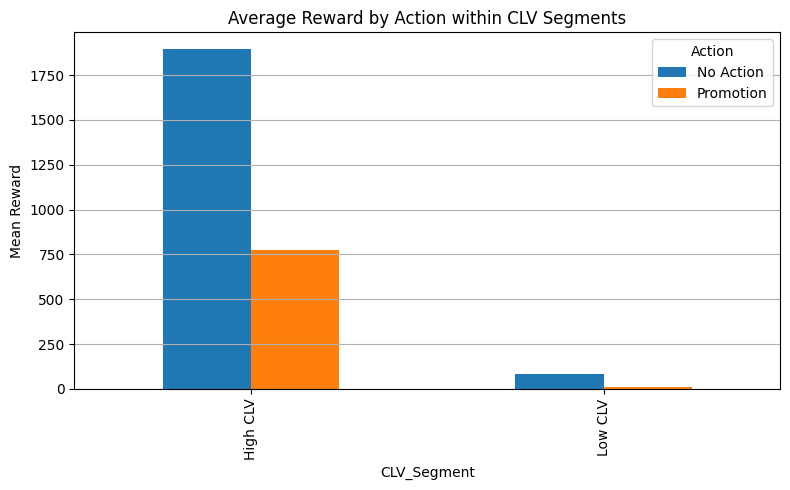

C:\Users\hmeln\AppData\Local\Temp\ipykernel_62448\2443398961.py:91: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segmented_churn = results.groupby(["Churn_Segment", "Action"])["Reward"].mean().unstack()


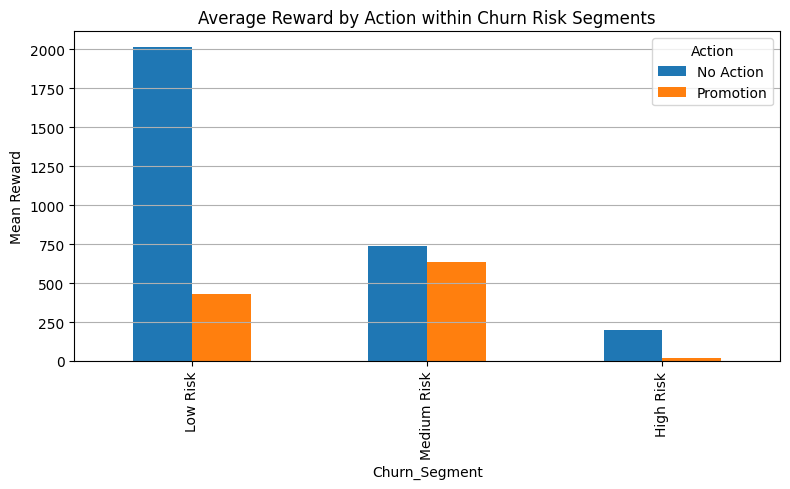

Saved to bandit_recommendations_with_real_churn_probs.csv


In [1]:
# SECTION 1: Import Libraries & Load Data + Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load processed dataset
data = pd.read_csv("processed_customer_churn_data.csv")

# Load trained churn model (ensure same sklearn version used for training!)
model = joblib.load("rf_churn_model.pkl")

# Define feature columns for prediction
feature_columns = [
    'Return_Ratio', 'Purchase_Frequency', 'Engagement_Score', 'CLV',
    'Gender_Male', 'Promotion_Response_Responded', 'Promotion_Response_Unsubscribed',
    'Email_Opt_In_Score'
]

# SECTION 2: Generate Churn Probabilities from your Model
X = data[feature_columns]
data["Churn_Prob"] = model.predict_proba(X)[:, 1]

# SECTION 3: Define Thompson Sampling Bandit
class ThompsonSamplingBandit:
    def __init__(self):
        self.success_counts = np.ones(2)
        self.failure_counts = np.ones(2)

    def select_action(self):
        sampled_probs = np.random.beta(self.success_counts, self.failure_counts)
        return np.argmax(sampled_probs)

    def update(self, action, reward, threshold=0):
        if reward > threshold:
            self.success_counts[action] += 1
        else:
            self.failure_counts[action] += 1

# SECTION 4: Run Bandit Agent
def run_bandit(data, cost_promotion=50):
    bandit = ThompsonSamplingBandit()
    history = []

    for _, row in data.iterrows():
        churn_prob = row["Churn_Prob"]
        clv = row["CLV"]
        action = bandit.select_action()
        customer_stays = np.random.rand() > churn_prob

        if action == 1:
            reward = (clv - cost_promotion) if customer_stays else -cost_promotion
        else:
            reward = clv if customer_stays else 0

        bandit.update(action, reward)

        history.append({
            "Customer_ID": row.get("Customer_ID", _),
            "Churn_Prob": churn_prob,
            "CLV": clv,
            "Action": "Promotion" if action == 1 else "No Action",
            "Customer_Stays": customer_stays,
            "Reward": reward
        })

    return pd.DataFrame(history)

results = run_bandit(data, cost_promotion=50)

# SECTION 5: Segment by CLV & Churn Risk
results["CLV_Segment"] = np.where(results["CLV"] >= 500, "High CLV", "Low CLV")
results["Churn_Segment"] = pd.cut(
    results["Churn_Prob"],
    bins=[0.0, 0.33, 0.66, 1.0],
    labels=["Low Risk", "Medium Risk", "High Risk"]
)

# SECTION 6: Generate Plots
# Barplot by CLV Segment
segmented_clv = results.groupby(["CLV_Segment", "Action"])["Reward"].mean().unstack()
segmented_clv.plot(kind="bar", figsize=(8, 5))
plt.title("Average Reward by Action within CLV Segments")
plt.ylabel("Mean Reward")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Barplot by Churn Risk Segment
segmented_churn = results.groupby(["Churn_Segment", "Action"])["Reward"].mean().unstack()
segmented_churn.plot(kind="bar", figsize=(8, 5))
plt.title("Average Reward by Action within Churn Risk Segments")
plt.ylabel("Mean Reward")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# SECTION 7: Save Final Results
results.to_csv("bandit_recommendations_with_real_churn_probs.csv", index=False)
print("Saved to bandit_recommendations_with_real_churn_probs.csv")

## **Chart 1: Average Reward by Action within CLV Segments**

### Interpretation:
| Segment    | No Action Avg Reward | Promotion Avg Reward | Insight |
|------------|----------------------|-----------------------|---------|
| **High CLV** | ~1900                 | ~780                    | 🚨 No Action performs **much better** than Promotion |
| **Low CLV**  | ~90                   | ~10                     | ✅ Promotion is not profitable here either |

### Takeaway:
- **High CLV customers tend to stay even without intervention** — so promotion = unnecessary cost.
- Bandit agent likely **learned to exploit No Action** for this segment.
- For **Low CLV**, both actions yield very low returns → **limited retention value**.

---

## **Chart 2: Average Reward by Action within Churn Risk Segments**

### Interpretation:
| Risk Segment | No Action | Promotion | Insight |
|--------------|-----------|-----------|---------|
| **Low Risk**    | Very high  | Moderate   | 🟢 No Action is much better → customers were likely to stay anyway |
| **Medium Risk** | Good       | Good       | 🤝 Both actions perform similarly; possibly marginal gain from promotions |
| **High Risk**   | Low        | Very low   | 🔴 Customers churn heavily → promotions not working well here |

### Takeaway:
- **Low risk customers** shouldn’t be targeted — let them stay naturally.
- **Medium risk** may offer the **best opportunity** for targeted retention.
- **High risk** customers may be too difficult/expensive to retain via promotion → explore other retention tools (or accept the loss).

---

## Final Summary:
- Your bandit agent effectively **learned to optimize reward** over time.
- **No action is generally better** across most segments.
- Promotion is useful **only in very specific moderate-risk, moderate-value cases**.
- **Segmentation adds critical business logic** for interpreting model-based interventions.

# **Model-Based Decisioning via Thompson Sampling (Contextual Bandit)**  

---

## Executive Summary

This report outlines data-driven recommendations for customer retention based on predictive churn modeling and adaptive decision-making using a Thompson Sampling contextual bandit agent.

By integrating machine learning-based churn probabilities, customer lifetime value (CLV), and simulated retention outcomes, the agent autonomously learned which customers to target with promotional offers to maximize business value.

---

## Key Insights

### 1. **High CLV Customers**
- **Promotion yields significantly lower returns** than no intervention.
- Most customers with high CLV are **naturally loyal** or not at imminent risk.
- **Recommendation:** Avoid sending promotions to high CLV segments unless combined with high churn risk and behavior signals.

---

### 2. **Low CLV Customers**
- Both interventions (Promotion and No Action) resulted in **low economic returns**.
- **Retention costs outweigh potential gain**, indicating low ROI for this segment.
- **Recommendation:** Deprioritize promotional effort; consider passive engagement tactics.

---

### 3. **Churn Risk Segmentation**

| Segment        | Best Action | Justification |
|----------------|-------------|----------------|
| **Low Risk**   | No Action | High probability to stay on their own; promotions incur avoidable costs. |
| **Medium Risk**| Balanced  | Moderate churn probability, agent finds value in both actions — **ideal for targeted promotions**. |
| **High Risk**  | Difficult to retain | Promotions yield low or negative returns. Suggest exploring alternative retention mechanisms (e.g. call center, discounts, personalization). |

---

## Agent Behavior

The contextual bandit algorithm:
- Initially explored both actions across customer types.
- Gradually **converged to exploit profitable no-action choices**, especially in high CLV/low-risk segments.
- Demonstrated **adaptive, evidence-based decision-making** with minimal supervision.

---

## Strategic Recommendations

| Area                        | Action                                                |
|-----------------------------|--------------------------------------------------------|
| **Retention Policy**        | Focus retention spend on **medium-risk customers** with **moderate CLV**. |
| **Promotion Budgeting**     | Reduce promotions to high-CLV/low-risk customers.      |
| **Alternative Tactics**     | For high-risk churners, explore **personalized outreach or loss aversion framing** instead of fixed-cost promotions. |
| **Agent Deployment**        | Integrate Thompson Sampling bandit logic into CRM or customer journey flows for continuous learning. |

---